In [1]:
# import the libraris

import spacy
import numpy as np
import pandas as pd

from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import NMF

In [2]:
# load kardan spacy
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])

In [3]:
# estekhraje token haye ye matn va hazf kardan khat haye khali
def separate_punc(doc_text):
    return [token.text.lower() for token in nlp(doc_text) if token.text not in '\n\n \n\n\n!"-#$%&()--.*+,-/:;<=>?@[\\]^_`{|}~\t\n ']

In [4]:
# read data from QandA.csv
QandA = pd.read_csv('Q&A.csv')

In [5]:
# show 5 top of Q&A
QandA = QandA[0:88]
QandA.head()

,Story,Question,Answer
0,Dr. Noferesti teaches artificial intelligence,What course does Dr. Noferesti teach,artificial intelligence.
1,Dr. Samira Noferesti teaches artificial intell...,What course does Dr. Samira Noferesti teach,artificial intelligence.
2,Dr. Noferesti teaches database,What course does Dr. Noferesti teach,database.
3,Dr. Samira Noferesti teaches the operating system,What course does Dr. Samira Noferesti teach,operating system.
4,Dr. Samira Noferesti teaches databases,What course does Dr. Samira Noferesti teach,database.


In [6]:
# greftan tole bozorg tarin story va bozorg tarin question
# greftan tamame jomle ha dar kenare ham
strin = ''
max_question = 0
max_answer = 0
for i in range(len(QandA)):
    try:
        strin += QandA['Story'][i] + ' ' + QandA['Question'][i] + ' ' + QandA['Answer'][i] + ' '
    except:
        print(str(QandA['Story'][i]) + '\t' + str(QandA['Question'][i]) + '\t' + str(QandA['Answer'][i]))
    if max_question < len(QandA['Question'][i]):
        max_question = len(QandA['Question'][i])
    if max_answer < len(QandA['Answer'][i]):
        max_answer = len(QandA['Answer'][i])

In [7]:
strin[:500]

'Dr. Noferesti teaches artificial intelligence What course does Dr. Noferesti teach artificial intelligence. Dr. Samira Noferesti teaches artificial intelligence What course does Dr. Samira Noferesti teach artificial intelligence. Dr. Noferesti teaches database What course does Dr. Noferesti teach database. Dr. Samira Noferesti teaches the operating system What course does Dr. Samira Noferesti teach operating system. Dr. Samira Noferesti teaches databases What course does Dr. Samira Noferesti tea'

In [8]:
# estekhraje token haye kole matn
tokens = separate_punc(strin)

In [10]:
print(len(tokens))
print(max_question)
print(max_answer)

1434
81
27


In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokens)

In [12]:
tokenizer.word_docs

defaultdict(int,
            {'dr': 176,
             'noferesti': 33,
             'teaches': 88,
             'artificial': 14,
             'intelligence': 22,
             'what': 46,
             'course': 22,
             'does': 88,
             'teach': 88,
             'samira': 18,
             'database': 12,
             'the': 32,
             'operating': 12,
             'system': 12,
             'databases': 2,
             'rajaee': 24,
             'algorithm': 14,
             'design': 16,
             'mehri': 12,
             'discrete': 26,
             'construction': 18,
             'sargolzaei': 12,
             'computer': 26,
             'architecture': 14,
             'mohammad': 16,
             'hossein': 6,
             'rezaei': 20,
             'graph': 14,
             'theory': 12,
             'masoumeh': 10,
             'computational': 8,
             'baluchzehi': 22,
             'networking': 12,
             'nik': 10,
             'inter

In [13]:
# sakhte araye e az datahaye vorodi be sakhtare [['story.t1', 'story.t2', ...], ['question.t1', 'question.t2', ...],['answer.t1', 'answer.t2', ...], .....]
train_data = []
for i in range(len(QandA)):
    train_data.append([separate_punc(QandA['Story'][i]), separate_punc(QandA['Question'][i]), separate_punc(QandA['Answer'][i])])

In [14]:
train_data[0]

[['dr.', 'noferesti', 'teaches', 'artificial', 'intelligence'],
 ['what', 'course', 'does', 'dr.', 'noferesti', 'teach'],
 ['artificial', 'intelligence']]

In [14]:
set(train_data[0][0])

{'artificial', 'dr.', 'intelligence', 'noferesti', 'teaches'}

In [15]:
# ejade listi az token hayii ke tekrari nabashan
vocab = set()

for story, question, answer in train_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))
    vocab = vocab.union(set(answer))

In [16]:
vocab

{'al',
 'algorithm',
 'architecture',
 'artificial',
 'baluchzehi',
 'building',
 'circuits',
 'computational',
 'computer',
 'construction',
 'course',
 'courses',
 'database',
 'databases',
 'davood',
 'design',
 'discrete',
 'does',
 'dr',
 'dr.',
 'electrical',
 'emamdadi',
 'engineering',
 'fifth',
 'fourth',
 'graph',
 'hossein',
 'in',
 'intelligence',
 'internet',
 'mahdi',
 'masoumeh',
 'mehri',
 'mir',
 'mohammad',
 'networking',
 'nik',
 'no',
 'nofaresti',
 'noferesti',
 'operating',
 'rajaee',
 'reyhaneh',
 'rezaei',
 'samira',
 'sargolzaei',
 'semester',
 'sixth',
 'software',
 'system',
 'teach',
 'teaches',
 'the',
 'theory',
 'what',
 'yes'}

In [17]:
vocab_len = len(vocab) + 1

In [18]:
vocab_len

57

In [19]:
max_story_len = max([len(data[0]) for data in train_data])

In [20]:
max_story_len

12

In [21]:
max_question_len = max([len(data[1]) for data in train_data])

In [22]:
max_question_len

12

In [23]:
max_answer_len = max([len(data[2]) for data in train_data])

In [24]:
max_answer_len

2

In [25]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [26]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [27]:
tokenizer.word_index

{'courses': 1,
 'davood': 2,
 'al': 3,
 'database': 4,
 'theory': 5,
 'intelligence': 6,
 'computational': 7,
 'rajaee': 8,
 'course': 9,
 'hossein': 10,
 'emamdadi': 11,
 'construction': 12,
 'semester': 13,
 'teach': 14,
 'discrete': 15,
 'rezaei': 16,
 'mir': 17,
 'sixth': 18,
 'engineering': 19,
 'operating': 20,
 'fourth': 21,
 'teaches': 22,
 'algorithm': 23,
 'computer': 24,
 'mahdi': 25,
 'internet': 26,
 'mehri': 27,
 'baluchzehi': 28,
 'system': 29,
 'design': 30,
 'reyhaneh': 31,
 'nofaresti': 32,
 'building': 33,
 'masoumeh': 34,
 'in': 35,
 'databases': 36,
 'nik': 37,
 'yes': 38,
 'electrical': 39,
 'software': 40,
 'fifth': 41,
 'artificial': 42,
 'circuits': 43,
 'dr.': 44,
 'what': 45,
 'samira': 46,
 'dr': 47,
 'architecture': 48,
 'no': 49,
 'sargolzaei': 50,
 'noferesti': 51,
 'the': 52,
 'mohammad': 53,
 'does': 54,
 'networking': 55,
 'graph': 56}

In [28]:
train_story_text = []
train_question_text = []
train_answers = []

In [29]:
for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

In [30]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [31]:
len(train_story_seq)

88

In [32]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len, max_question_len=max_question_len, max_answer_len=max_answer_len):
    
    X = []
    Xq = []
    Y = []
    
    for story, query, answer in data:
        
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]
        
        y = np.zeros(len(word_index) + 1)
        
        y[word_index[answer[0]]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X, maxlen=max_story_len), pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [33]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [34]:
inputs_train[10]

array([ 0,  0,  0,  0,  0,  0,  0, 44, 50, 22, 24, 48], dtype=int32)

In [35]:
queries_train[1]

array([ 0,  0,  0,  0,  0, 45,  9, 54, 44, 46, 51, 14], dtype=int32)

In [36]:
answers_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
sum(answers_train)

array([ 0.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  4.,  0.,  0.,  2.,  0.,  2., 10.,  0.,  2.,  4.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 28.,
        1.,  0., 12.,  2.,  0.,  0.,  0.,  0.,  0.,  0., 14.,  0.,  0.,
        0.,  0.,  0.,  0.,  2.])

In [38]:
from keras.models import Sequential, Model

In [39]:
from keras.layers import Embedding

In [40]:
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

In [41]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [42]:
vocab_size = len(vocab) + 1

In [43]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))

In [44]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

In [45]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [46]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [47]:
match = dot([input_encoded_m, question_encoded], axes=(2,2))
match = Activation('softmax')(match)

In [48]:
response = add([match, input_encoded_c])
response = Permute((2, 1))(response)

In [49]:
answer = concatenate([response, question_encoded])

In [50]:
answer

<KerasTensor: shape=(None, 12, 76) dtype=float32 (created by layer 'concatenate')>

In [51]:
answer = LSTM(32)(answer)

In [52]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

In [53]:
answer = Activation('softmax')(answer)

In [54]:
model = Model([input_sequence, question], answer)

In [55]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 64)     3648        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 12, 64)       3648        input_2[0][0]                    
______________________________________________________________________________________________

In [57]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs=500, validation_data=([inputs_train, queries_train], answers_train))

Epoch 1/500
3/3 [==============================] - 4s 704ms/step - loss: 4.0301 - accuracy: 0.0785 - val_loss: 3.9700 - val_accuracy: 0.3182
Epoch 2/500
3/3 [==============================] - 0s 47ms/step - loss: 3.9624 - accuracy: 0.2713 - val_loss: 3.8950 - val_accuracy: 0.3182
Epoch 3/500
3/3 [==============================] - 0s 70ms/step - loss: 3.8791 - accuracy: 0.3271 - val_loss: 3.7505 - val_accuracy: 0.3182
Epoch 4/500
3/3 [==============================] - 0s 60ms/step - loss: 3.7097 - accuracy: 0.3679 - val_loss: 3.4861 - val_accuracy: 0.3182
Epoch 5/500
3/3 [==============================] - 0s 50ms/step - loss: 3.4306 - accuracy: 0.3271 - val_loss: 3.1878 - val_accuracy: 0.3182
Epoch 6/500
3/3 [==============================] - 0s 62ms/step - loss: 3.2275 - accuracy: 0.2880 - val_loss: 2.9842 - val_accuracy: 0.3182
Epoch 7/500
3/3 [==============================] - 0s 46ms/step - loss: 3.0855 - accuracy: 0.2997 - val_loss: 2.8846 - val_accuracy: 0.3182
Epoch 8/500
3/3 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


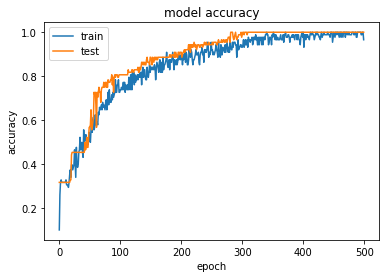

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
pred_results = model.predict(([inputs_train, queries_train]))

In [60]:
' '.join(train_data[30][1])

'does dr. noferesti teach artificial intelligence'

In [61]:
pred_results[30]

array([2.37452680e-09, 3.56347885e-09, 2.75264522e-09, 2.67624234e-09,
       3.70016693e-07, 3.29221117e-09, 1.13311449e-09, 7.12068777e-06,
       1.70516423e-09, 1.77724135e-09, 1.71722414e-09, 2.70388734e-09,
       1.96068650e-09, 2.88092061e-09, 1.01437758e-09, 3.76586650e-05,
       2.11719509e-09, 2.71991185e-09, 7.52353060e-07, 3.17571702e-09,
       2.50399125e-06, 9.18519072e-06, 1.62881797e-09, 1.06015905e-05,
       4.69846418e-06, 1.37065814e-09, 5.03705451e-06, 1.61847447e-09,
       2.54155030e-09, 4.68514116e-09, 2.63037769e-09, 3.88582277e-09,
       2.73786371e-09, 1.29690647e-09, 1.40135703e-09, 1.86156335e-09,
       2.54564969e-09, 2.10990647e-09, 9.99780118e-01, 4.09312264e-07,
       9.15082843e-10, 3.50366208e-05, 6.25659140e-06, 2.27126273e-09,
       2.95776270e-09, 2.16936313e-09, 2.80948576e-09, 1.34979417e-09,
       2.65413447e-09, 9.94530710e-05, 1.49869250e-09, 1.86466576e-09,
       2.29450126e-09, 1.06755305e-09, 7.89741883e-10, 1.70267478e-09,
      

In [62]:
val_max = np.argmax(pred_results[30])

In [63]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [64]:
k

'yes'

In [65]:
pred_results[30][val_max]

0.9997801

In [66]:
my_story = "Dr. Noferesti teaches artificial intelligence"

In [67]:
my_story.split()

['Dr.', 'Noferesti', 'teaches', 'artificial', 'intelligence']

In [68]:
my_question = "Dr. Noferesti teach electrical circuits"

In [69]:
my_question.split()

['Dr.', 'Noferesti', 'teach', 'electrical', 'circuits']

In [70]:
mydata = [(my_story.split(), my_question.split(), ['no'])]

In [71]:
my_story, my_ques, my_ans = vectorize_stories(mydata)

In [72]:
pred_results = model.predict(([my_story, my_ques]))

In [73]:
pred_results[0]

array([3.61351127e-08, 4.49304949e-08, 5.22435997e-08, 2.56982737e-08,
       3.33107278e-06, 6.79457770e-08, 1.79982074e-08, 4.05766732e-05,
       2.63219455e-08, 2.94845783e-08, 2.01441619e-08, 3.42602320e-08,
       2.09450963e-08, 2.94334459e-08, 1.15951000e-08, 3.87315304e-05,
       2.75215193e-08, 5.20761638e-08, 5.94594121e-06, 4.13738341e-08,
       1.80616153e-05, 1.37704228e-05, 2.70335114e-08, 1.83181055e-05,
       8.98843427e-06, 1.89145961e-08, 5.74387923e-05, 2.18877698e-08,
       3.49288882e-08, 6.83276014e-08, 3.05639389e-08, 5.16868717e-08,
       3.77193352e-08, 1.68143277e-08, 1.62669131e-08, 2.71214642e-08,
       3.27420722e-08, 3.26531371e-08, 9.99514580e-01, 7.84542010e-07,
       1.30874955e-08, 1.48712206e-04, 6.85051709e-05, 2.46972007e-08,
       5.37204272e-08, 2.75322289e-08, 4.68776911e-08, 1.61549831e-08,
       4.25306546e-08, 6.02210639e-05, 2.31682371e-08, 3.47091991e-08,
       3.40772317e-08, 1.27114292e-08, 1.16391945e-08, 3.44766171e-08,
      

In [74]:
val_max = np.argmax(pred_results[0])
print(val_max)

38


In [75]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [76]:
k

'yes'